In [32]:
from tmu.tsetlin_machine import TMCoalescedClassifier
import numpy as np 
import pickle
import torch
from tabulate import tabulate
import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from itertools import combinations
# from apriori_python import apriori
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import seaborn as sns
import matplotlib.pyplot as plt
!export OMP_NUM_THREADS=10
n_clauses_per_class = 8000
treshold = int(n_clauses_per_class * 0.8)
s_param = 11.40000000000001
# s_param = 5

"s henger sammen hvor ofte du ser pattern"
"lav s sier at man ser et pattern ofte, og kan glemme dette"
"belonning er s/(s-1)"
"random penalty er 1/s"

'random penalty er 1/s'

In [2]:
cuda_tm = TMCoalescedClassifier(n_clauses_per_class, treshold, s_param,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=False)

In [3]:
neg_cuda_tm = TMCoalescedClassifier(n_clauses_per_class, treshold, s_param,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=True)

In [4]:
game_amount = 100000
# tsetlin_filename = "/home/jaoi/master22/pet_for_sale/winning_games_db/4PPO_{}_cum_left_tsetlined_games.pkl".format(number_of_games)
# tsetlin_filename, self_can_bet_index= "/home/jaoi/master22/pet_for_sale/winning_games_db/{}_tsetlined_games.pkl".format(game_amount), 17
tsetlin_filename, self_can_bet_index = "/home/jaoi/master22/pet_for_sale/winning_games_db/4PPO_{}_cum_left_tsetlined_games.pkl".format(game_amount), 163

with open(tsetlin_filename, "rb") as fp:
        games = pickle.load(fp)

In [5]:
# preprossesing
def remove_duplicate_pairs(games):
    new_games = []
    for i,game in enumerate(games):
        int_arr = game[0].astype(int)
        complete_arr = np.append(int_arr, game[1])
        new_games.append(complete_arr)

    new_games = np.array(new_games)
    
    x = np.random.rand(new_games.shape[1])
    y = new_games.dot(x)
    unique, index = np.unique(y, return_index=True)
    unique_xy = new_games[index]
    
    unique_pairs = []
    for game in unique_xy:
        last, rest = game[-1], game[:-1]
        unique_pairs.append(np.array((rest.astype(np.float32), last), dtype=object))
    return np.array(unique_pairs)


def oversample(info_tup, desired_amount, source_games):
    bob = []
    for game in source_games:
        if game[1] == info_tup[0]:
            bob.append(game)
    indexes = np.random.randint(0, info_tup[1], desired_amount - info_tup[1])
    temp = []
    for ind in indexes:
        temp.append(bob[ind])
    return np.array(temp)


def preprocess_games(games):
    
    where_can = []
    for i, game in enumerate(games):
        if game[0][self_can_bet_index] == 1:
            where_can.append(i)
    indexes = np.array(where_can)
    print("past indexes")
    games_can_bid = games[indexes]

    unique_pairs = remove_duplicate_pairs(games_can_bid)
    print("past unique pairs")
    ysu = Counter()
    for game in unique_pairs:
        ysu[game[1]] += 1
    
    need_of_oversample = [tup for tup in ysu.most_common() if tup[1] < 2000]
    print("past unique need of oversample")
    


    unique_oversample = np.copy(unique_pairs)
    temp = []
    for overnd in need_of_oversample:
        temp.extend(oversample(overnd, 2000, unique_pairs))
    unique_oversample = np.concatenate((unique_oversample, np.array(temp)), axis=0)
    print("past unique oversample")
    
    uo = Counter()
    for game in unique_oversample:
        uo[game[1]] += 1
    print(uo)
    return unique_oversample

unique_oversample = preprocess_games(games)

past indexes
past unique pairs
past unique need of oversample
past unique oversample
Counter({4: 73819, 0: 68361, 6: 49399, 2: 43261, 3: 36861, 8: 29469, 5: 24829, 7: 15721, 9: 11462, 10: 11244, 11: 4814, 12: 3039, 1: 2000, 13: 2000, 14: 2000, 15: 2000, 16: 2000})


In [6]:
x =np.array([game[0] for game in unique_oversample[:, :1]])
y =np.array([game[0] for game in unique_oversample[:, 1:]])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2)
# remove self bid feature, which is at index 21
x_train = np.delete(x_train, self_can_bet_index, 1)
x_test = np.delete(x_test, self_can_bet_index, 1)

In [8]:
x_train.shape

(305823, 556)

In [9]:
neg_cuda_tm = TMCoalescedClassifier(n_clauses_per_class, treshold, s,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=True)

NameError: name 's' is not defined

In [405]:
"""NEW BEST ACC! At Epoch 0 s 40.400000000000006 Accuracy tm: 80.8700429004918
NEW BEST ACC! At Epoch 1 s 40.400000000000006 Accuracy tm: 82.3336298001465"""

'NEW BEST ACC! At Epoch 0 s 40.400000000000006 Accuracy tm: 80.8700429004918\nNEW BEST ACC! At Epoch 1 s 40.400000000000006 Accuracy tm: 82.3336298001465'

In [10]:
best_models = []

In [12]:
# for s in [0.1, 5, 10, 15, 20, 25, 30, 35, 40]:
best_acc = 0
for i in range(15):
    s = np.random.choice(np.arange(0.1, 50, 0.1))
    neg_cuda_tm = TMCoalescedClassifier(n_clauses_per_class, treshold, s,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=True)
    epochs = 2
    for epoch in range(epochs):
        neg_cuda_tm.fit(x_train, y_train)
        acc = 100*(neg_cuda_tm.predict(x_test) == y_test).mean()
        if acc > best_acc:
            best_acc = acc
            best_models.append((acc, neg_cuda_tm))
            print("NEW BEST ACC! At Epoch {} s {} Accuracy tm:".format(epoch, s), acc)
        else:
            print("Epoch {} s{} Accuracy tm:".format(epoch, s), acc)

NEW BEST ACC! At Epoch 0 s 14.3 Accuracy tm: 79.98587422831433
NEW BEST ACC! At Epoch 1 s 14.3 Accuracy tm: 82.71816469603432


KeyboardInterrupt: 

In [250]:
# best_tms = []
best_tms

[(74.50559799100137,
  <tmu.tsetlin_machine.TMCoalescedClassifier at 0x7f3783285c40>),
 (77.11624986920582,
  <tmu.tsetlin_machine.TMCoalescedClassifier at 0x7f3783285c40>),
 (77.33467615360469,
  <tmu.tsetlin_machine.TMCoalescedClassifier at 0x7f378a9aab50>),
 (77.61065187820446,
  <tmu.tsetlin_machine.TMCoalescedClassifier at 0x7f37831a3790>),
 (77.63942659830491,
  <tmu.tsetlin_machine.TMCoalescedClassifier at 0x7f37831a3790>)]

In [98]:
best_acc = best_tms[-1][0]
s = 15.5
cuda_tm = TMCoalescedClassifier(n_clauses_per_class, treshold, s,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=False)
# for i in range(15):
#     s = np.random.choice(np.arange(0.1, 50, 0.1))
#     cuda_tm = TMCoalescedClassifier(n_clauses_per_class, treshold, s,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=False)
epochs = 100
for epoch in range(epochs):
    cuda_tm.fit(x_train, y_train)
    acc = 100*(cuda_tm.predict(x_test) == y_test).mean()
    if acc > best_acc:
        best_acc = acc
        best_tms.append((acc, cuda_tm))
        print("NEW BEST ACC! At Epoch {} s {} Accuracy tm:".format(epoch, s), acc)
    else:
        print("Epoch {} s {} Accuracy tm:".format(epoch, s), acc)

Epoch 0 s 15.5 Accuracy tm: 75.27205189913153
Epoch 1 s 15.5 Accuracy tm: 77.0966307418646
Epoch 2 s 15.5 Accuracy tm: 77.28105053887204
Epoch 3 s 15.5 Accuracy tm: 77.581877158104
Epoch 4 s 15.5 Accuracy tm: 77.2444281678351
Epoch 5 s 15.5 Accuracy tm: 77.02338599979073
Epoch 6 s 15.5 Accuracy tm: 75.80438422098985
Epoch 7 s 15.5 Accuracy tm: 73.77969027937638
Epoch 8 s 15.5 Accuracy tm: 74.45328031809146
Epoch 9 s 15.5 Accuracy tm: 74.08313278225384
Epoch 10 s 15.5 Accuracy tm: 74.88882494506645
Epoch 11 s 15.5 Accuracy tm: 74.18515224442817
Epoch 12 s 15.5 Accuracy tm: 72.76865125039238
Epoch 13 s 15.5 Accuracy tm: 73.69075023542952
Epoch 14 s 15.5 Accuracy tm: 73.1309511352935
Epoch 15 s 15.5 Accuracy tm: 70.91137386209061
Epoch 16 s 15.5 Accuracy tm: 72.48090404938789
Epoch 17 s 15.5 Accuracy tm: 70.98331066234174
Epoch 18 s 15.5 Accuracy tm: 69.24374803808726
Epoch 19 s 15.5 Accuracy tm: 71.06047922988385
Epoch 20 s 15.5 Accuracy tm: 70.1736946740609
Epoch 21 s 15.5 Accuracy tm: 

In [156]:
tm_ensamble = best_tms[-3:]
tm_ensamble

[(77.33467615360469,
  <tmu.tsetlin_machine.TMCoalescedClassifier at 0x7f378a9aab50>),
 (77.61065187820446,
  <tmu.tsetlin_machine.TMCoalescedClassifier at 0x7f37831a3790>),
 (77.63942659830491,
  <tmu.tsetlin_machine.TMCoalescedClassifier at 0x7f37831a3790>)]

In [306]:
def get_name_of_feature_from_cum_4_rounds(feature_nr):
    total_features = 556
    feature_nr = int(feature_nr)
    money_len = 18
    score_len = 62
    order_len = 3
    stack_len = 15
    board_card_len = 15
    can_bid_len = 1
    leading_bits = [1, 2, 3]
    money_values = list(range(1, 19))
    score_values = list(range(1, 63))
    stack_values = list(range(1, 16))
    board_values = list(range(1, 16))
    cards_left_values = list(range(1, 5))
    
    # for self
    if feature_nr in list(range(money_len)):
        return "self coins {}".format(money_values[feature_nr])
    elif feature_nr in list(range(money_len, money_len+score_len)):
        return "self tot score {}".format(score_values[feature_nr - money_len]) 
    elif feature_nr in list(range(money_len+score_len, money_len*2 + score_len)):
        return "self bid {}".format(money_values[feature_nr - (money_len+score_len)])
    elif feature_nr in list(range(money_len*2 + score_len, money_len*2 + score_len*2)):
        return "self pass score {}".format(score_values[feature_nr - (money_len*2 + score_len)])
    elif feature_nr in list(range(money_len*2 + score_len*2, money_len*2 + score_len*2 + order_len)):
        return "self order {}".format(leading_bits[feature_nr - (money_len*2 + score_len*2)])
    
    # for next player
    elif feature_nr in list(range(money_len*2 + score_len*2 + order_len, money_len*3 + score_len*2 + order_len)):
        return "next coins {}".format(money_values[feature_nr - (money_len*2 + score_len*2 + order_len)]) 
    elif feature_nr in list(range(money_len*3 + score_len*2 + order_len, money_len*3 + score_len*3 + order_len)):
        return "next tot score {}".format(score_values[feature_nr - (money_len*3 + score_len*2 + order_len)])
    elif feature_nr in list(range(money_len*3 + score_len*3 + order_len, money_len*4 + score_len*3 + order_len)):
        return "next bid {}".format(money_values[feature_nr - (money_len*3 + score_len*3 + order_len)])
    elif feature_nr in list(range(money_len*4 + score_len*3 + order_len, money_len*4 + score_len*4 + order_len)):
        return "next pass score {}".format(score_values[feature_nr - (money_len*4 + score_len*3 + order_len)])
    elif feature_nr in list(range(money_len*4 + score_len*4 + order_len, money_len*4 + score_len*4 + order_len*2)):
        return "next order {}".format(leading_bits[feature_nr - (money_len*4 + score_len*4 + order_len)])
    elif feature_nr == (money_len*4 + score_len*4 + order_len*2):
        return "next can bid  "
    
    # for final player
    elif feature_nr in list(range(money_len*4 + score_len*4 + order_len*2 + can_bid_len, money_len*5 + score_len*4 + order_len*2 + can_bid_len)):
        return "final coins {}".format(money_values[feature_nr - (money_len*4 + score_len*4 + order_len*2 + can_bid_len)])
    elif feature_nr in list(range(money_len*5 + score_len*4 + order_len*2 + can_bid_len, money_len*5 + score_len*5 + order_len*2 + can_bid_len)):
        return "final tot score {}".format(score_values[feature_nr - (money_len*5 + score_len*4 + order_len*2 + can_bid_len)])
    elif feature_nr in list(range(money_len*5 + score_len*5 + order_len*2 + can_bid_len, money_len*6 + score_len*5 + order_len*2 + can_bid_len)):
        return "final bid {}".format(money_values[feature_nr - (money_len*5 + score_len*5 + order_len*2 + can_bid_len)])
    elif feature_nr in list(range(money_len*6 + score_len*5 + order_len*2 + can_bid_len, money_len*6 + score_len*6 + order_len*2 + can_bid_len)):
        return "final pass score {}".format(score_values[feature_nr - (money_len*6 + score_len*5 + order_len*2 + can_bid_len)])
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*2 + can_bid_len, money_len*6 + score_len*6 + order_len*3 + can_bid_len)):
        return "final order {}".format(leading_bits[feature_nr - (money_len*6 + score_len*6 + order_len*2 + can_bid_len)])
    elif feature_nr == (money_len*6 + score_len*6 + order_len*3 + can_bid_len):
        return "final can bid  "
    
    # boardstuff 
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + can_bid_len*2, money_len*6 + score_len*6 + order_len*3 + stack_len + can_bid_len*2)):
        return "stack card {}".format(stack_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + can_bid_len*2)]) 
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + stack_len + can_bid_len*2, money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len + can_bid_len*2)):
        return "1. card {}".format(board_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + stack_len + can_bid_len*2)])
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len + can_bid_len*2, money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*2 + can_bid_len*2)):
        return "2. card {}".format(board_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len + can_bid_len*2)])
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*2 + can_bid_len*2, money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2)):
        return "3. card {}".format(board_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*2 + can_bid_len*2)])
    elif feature_nr == money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2:
        return "std bit  "
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2 + 1, money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2 + 1 + 4)):
        return "cards to aquire {}".format(cards_left_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2 + 1)])
    
    

In [310]:
def double(lst):
    try:
        return [i+556 for i in lst]
    except TypeError:
        print(lst)

def reduce_neg_coalesce_literals_4r(tm, clause):
    # negation
    # else:
    # l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
    own_money = list(range(18))
    high_own_money = (0, "")
    neg_own_money = (0, "")
    own_total_score = list(range(18, 80))
    high_own_total_score = (0, "")
    neg_own_total_score = (0, "")
    own_bid = list(range(80, 98))
    high_own_bid = (0, "")
    neg_own_bid = (0, "")
    own_pass_score = list(range(98, 160))
    high_own_pass_score = (0, "")
    neg_own_pass_score = (0, "")
    own_pass_order = list(range(160, 163))
    
    next_coins = list(range(163, 181))
    high_next_coins = (0, "")
    neg_next_coins = (0, "")
    next_tot_score = list(range(181, 243))
    high_next_tot_score = (0, "")
    neg_next_tot_score = (0, "")
    next_bid = list(range(243, 261))
    high_next_bid = (0, "")
    neg_next_bid = (0, "")
    next_pass_score = list(range(261, 323))
    high_next_pass_score = (0, "")
    neg_next_pass_score = (0, "")
    next_order = list(range(323, 326))
    next_can_bid = 326

    final_coins = list(range(327, 345))
    high_final_coins = (0, "")
    neg_final_coins = (0, "")
    final_tot_score = list(range(345, 407))
    high_final_tot_score = (0, "")
    neg_final_tot_score = (0, "")
    final_bid = list(range(407, 425))
    high_final_bid = (0, "")
    neg_final_bid = (0, "")
    final_pass_score = list(range(425, 487))
    high_final_pass_score = (0, "")
    neg_final_pass_score = (0, "")
    final_order = list(range(487, 490))
    final_can_bid = 490

    stack_card = list(range(491, 506))
    board_c1 = list(range(506, 521))
    high_board_c1 = (0, "")
    neg_board_c1 = (0, "")
    board_c2 = list(range(521, 536))
    high_board_c2 = (0, "")
    neg_board_c2 = (0, "")
    board_c3 = list(range(536, 551))
    high_board_c3 = (0, "")
    neg_board_c3 = (0, "")
    std_bit = 551
    cards_to_aquire = list(range(552, 556))
    high_cards_to_aquire = (0, "")
    neg_cards_to_aquire = (0, "")
    

    
    number_of_features = 556
    l = []
    for k in range(number_of_features*2):
        if tm.get_ta_action(clause, k) == 1 and (k in own_money or k in double(own_money)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k) 
                if int(name[-2:]) > high_own_money[0]:
                    high_own_money = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_own_money[0]:
                    neg_own_money = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in own_total_score or k in double(own_total_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_total_score[0]:
                    high_own_total_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_own_total_score[0]:
                    neg_own_total_score = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in own_bid or k in double(own_bid)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_bid[0]:
                    high_own_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_own_bid[0]:
                    neg_own_bid = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in own_pass_score or k in double(own_pass_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_pass_score[0]:
                    high_own_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_own_pass_score[0]:
                    neg_own_pass_score = (int(name[-2:]), name)
                    
        # find out what to do about this one!
        elif tm.get_ta_action(clause, k) == 1 and (k in own_pass_order or k in double(own_pass_order)):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                
                  
        elif tm.get_ta_action(clause, k) == 1 and (k in next_coins or k in double(next_coins)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_coins[0]:
                    high_next_coins = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_next_coins[0]:
                    neg_next_coins = (int(name[-2:]), name)
                    
            
        elif tm.get_ta_action(clause, k) == 1 and (k in next_tot_score or k in double(next_tot_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_tot_score[0]:
                    high_next_tot_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_next_tot_score[0]:
                    neg_next_tot_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in next_bid or k in double(next_bid)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_bid[0]:
                    high_next_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_next_bid[0]:
                    neg_next_bid = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in next_pass_score or k in double(next_pass_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_pass_score[0]:
                    high_next_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_next_pass_score[0]:
                    neg_next_pass_score = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in next_order or k in double(next_order)):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                
        elif tm.get_ta_action(clause, k) == 1 and (k == next_can_bid or k == next_can_bid + number_of_features):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))        
                
        elif tm.get_ta_action(clause, k) == 1 and (k in final_coins or k in double(final_coins)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_coins[0]:
                    high_final_coins = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_final_coins[0]:
                    neg_final_coins = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in final_tot_score or k in double(final_tot_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_tot_score[0]:
                    high_final_tot_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_final_tot_score[0]:
                    neg_final_tot_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in final_bid or k in double(final_bid)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_bid[0]:
                    high_final_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_final_bid[0]:
                    neg_final_bid = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in final_pass_score or k in double(final_pass_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_pass_score[0]:
                    high_final_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_final_pass_score[0]:
                    neg_final_pass_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in final_order or k in double(final_order)):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
                # l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
        elif tm.get_ta_action(clause, k) == 1 and (k == final_can_bid or k == final_can_bid + number_of_features):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
        elif tm.get_ta_action(clause, k) == 1 and (k in stack_card or k in double(stack_card)):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
        elif tm.get_ta_action(clause, k) == 1 and (k in board_c1 or k in double(board_c1)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c1[0]:
                    high_board_c1 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_board_c1[0]:
                    neg_board_c1 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in board_c2 or k in double(board_c2)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c2[0]:
                    high_board_c2 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_board_c2[0]:
                    neg_board_c2 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in board_c3 or k in double(board_c3)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c3[0]:
                    high_board_c3 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_board_c3[0]:
                    neg_board_c3 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k == std_bit or k == std_bit + number_of_features):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                
        elif tm.get_ta_action(clause, k) == 1 and (k in cards_to_aquire or k in double(cards_to_aquire)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_cards_to_aquire[0]:
                    high_cards_to_aquire = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_cards_to_aquire[0]:
                    neg_cards_to_aquire = (int(name[-2:]), name)
                    
        # else:
        #     if k < number_of_features:
        #         l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
    
    l.append(high_own_money[1]) if high_own_money[1] != "" else None
    l.append(neg_own_money[1]) if neg_own_money[1] != "" else None
    l.append(high_own_bid[1]) if high_own_bid[1] != "" else None
    l.append(neg_own_bid[1]) if neg_own_bid[1] != "" else None
    l.append(high_own_total_score[1]) if high_own_total_score[1] != "" else None
    l.append(neg_own_total_score[1]) if neg_own_total_score[1] != "" else None
    l.append(high_own_pass_score[1]) if high_own_pass_score[1] != "" else None
    l.append(neg_own_pass_score[1]) if neg_own_pass_score[1] != "" else None
    
    l.append(high_next_coins[1]) if high_next_coins[1] != "" else None
    l.append(neg_next_coins[1]) if neg_next_coins[1] != "" else None
    l.append(high_next_tot_score[1]) if high_next_tot_score[1] != "" else None
    l.append(neg_next_tot_score[1]) if neg_next_tot_score[1] != "" else None
    l.append(high_next_bid[1]) if high_next_bid[1] != "" else None
    l.append(neg_next_bid[1]) if neg_next_bid[1] != "" else None
    l.append(high_next_pass_score[1]) if high_next_pass_score[1] != "" else None
    l.append(neg_next_pass_score[1]) if neg_next_pass_score[1] != "" else None
    
    l.append(high_final_coins[1]) if high_final_coins[1] != "" else None
    l.append(neg_final_coins[1]) if neg_final_coins[1] != "" else None
    l.append(high_final_tot_score[1]) if high_final_tot_score[1] != "" else None
    l.append(neg_final_tot_score[1]) if neg_final_tot_score[1] != "" else None
    l.append(high_final_bid[1]) if high_final_bid[1] != "" else None
    l.append(neg_final_bid[1]) if neg_final_bid[1] != "" else None
    l.append(high_final_pass_score[1]) if high_final_pass_score[1] != "" else None
    l.append(neg_final_pass_score[1]) if neg_final_pass_score[1] != "" else None
    
    l.append(high_board_c1[1]) if high_board_c1[1] != "" else None
    l.append(neg_board_c1[1]) if neg_board_c1[1] != "" else None
    l.append(high_board_c2[1]) if high_board_c2[1] != "" else None
    l.append(neg_board_c2[1]) if neg_board_c2[1] != "" else None
    l.append(high_board_c3[1]) if high_board_c3[1] != "" else None
    l.append(neg_board_c3[1]) if neg_board_c3[1] != "" else None
    l.append(high_cards_to_aquire[1]) if high_cards_to_aquire[1] != "" else None
    l.append(neg_cards_to_aquire[1]) if neg_cards_to_aquire[1] != "" else None
    
    l = [i for i in l if i != ""]
    return l

In [252]:
reduce_neg_coalesce_literals_4r(neg_cuda_tm, 65)

['self coins 7',
 '¬self bid 4',
 'self pass score 10',
 '¬self pass score 50',
 '¬next coins 10',
 '¬next tot score 60',
 '¬next bid 18',
 '¬final coins 16',
 '¬final tot score 60',
 '¬final bid 6',
 'final pass score 11',
 '¬final pass score 52',
 '1. card 4']

In [346]:
print(best_models[-1][1].predict(x_test[10].reshape(1, -1))[0])
c_out = best_models[-1][1].transform(x_test[10].reshape(1, -1))
clauses_out = np.where(c_out == 1)[1].astype(int)
mw = best_models[-1][1].weight_banks[best_models[-1][1].predict(x_test[10].reshape(1, -1))[0]].get_weights()
new_c_out = mw[clauses_out]
# clauses_out = clauses_out[new_c_out > 0]

top5 = np.argpartition(clauses_out, -5)[-5:]
clauses_out = clauses_out[top5]
targets = []
for i, clause in enumerate(clauses_out):
    if i == 10:
        break
    targets.append(reduce_neg_coalesce_literals_4r(best_models[-1][1], clause))
target_df = pd.DataFrame(targets)
print(target_df.to_latex(index=False))

6
\begin{tabular}{lllllllllllllllllllllll}
\toprule
              0  &                1  &                 2  &                 3  &                 4  &                  5  &                  6  &                  7  &                 8  &                 9  &                  10 &                  11 &                 12 &                   13 &                  14 &                 15 &                  16 &                   17 &                   18 &                   19 &          20 &                 21 &                 22 \\
\midrule
   ¬self coins 7 & self tot score 14 & self pass score 21 &   next tot score 7 & ¬next tot score 58 &  next pass score 16 & ¬next pass score 51 & ¬final tot score 60 &      ¬final bid 12 &               None &                None &                None &               None &                 None &                None &               None &                None &                 None &                 None &                 None &        None &     

/tmp/ipykernel_1813360/4400789.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(target_df.to_latex(index=False))


In [277]:
c_out = best_models[-1][1].transform(x_test[10].reshape(1, -1))
clauses_out = np.where(c_out == 1)[1].astype(int)

def get_complete_interval(tm, clauses, literals):
    intervals = {}
    for literal in literals[0]:
        # print(literal)
        neg_interval = np.zeros(literals[1]+1)
        pos_interval = np.zeros(literals[1]+1)
        
        for clause in clauses:
            # print(sorted(literals))
            reduced = reduce_neg_coalesce_literals_4r(tm, clause)
            extracted_reduced = [result for result in reduced if literal in result]

            for ex in extracted_reduced:
                try:
                    if ex.startswith(literal):
                        pos_interval[int(ex[-2:])] += 1
                    elif ex.startswith("¬"+literal):
                        neg_interval[int(ex[-2:])] += 1
                except ValueError:
                    print("something was wrong with: ", ex)
                    if ex.startswith("¬"+literal):
                        neg_interval[0] += 1
                    elif ex.startswith(literal):
                        pos_interval[0] += 1
                # else:
            #     interval_dict[literal_type][int(ex[-2:])] += 1
        intervals[literal] = pos_interval
        intervals["¬"+literal] = neg_interval
    return intervals
#plot green vs red for each literal

def create_whole_plots_from_single_example_with_y(tm, ex, y):
    ex = np.delete(ex, self_can_bet_index)
    c_out = tm.transform(ex.reshape(1, -1))
    clauses_out = np.where(c_out == 1)[1].astype(int)
    mw = tm.weight_banks[y].get_weights()
    new_c_out = mw[clauses_out]
    clauses_out = clauses_out[new_c_out > 0]
    grouped_intervals = defaultdict(list)
    for group in groups_and_value:
        grouped_intervals[group[0]] = get_complete_interval(tm, clauses_out, (group[1], group[2]))
    return grouped_intervals

neg_plot_data_e4 = create_whole_plots_from_single_example_with_y(neg_cuda_tm, example4, 4)


something was wrong with:  final can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬next can bid  
something was wrong with:  ¬std bit  
something was wrong with:  ¬std bit  
something was wrong w

In [279]:
neg_plot_data_e4

defaultdict(list,
            {'cards': {'1. card': array([ 0., 15.,  6., 12., 14., 19.,  7., 10., 14., 15., 16., 14., 17.,
                     10.,  6.,  0.]),
              '¬1. card': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6.]),
              '2. card': array([ 0., 17., 21., 16.,  8., 10., 12., 14., 11.,  0.,  0.,  0.,  0.,
                      0.,  0.,  0.]),
              '¬2. card': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  9.,  6., 12.,
                      9., 13., 25.]),
              '3. card': array([ 0., 22., 16., 13.,  4.,  7., 12.,  6.,  0.,  0.,  0.,  0.,  0.,
                      0.,  0.,  0.]),
              '¬3. card': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  8., 16., 27.,  8.,
                     20., 22., 30.]),
              'stack card': array([ 0.,  5.,  0.,  0.,  8.,  3.,  1.,  9.,  3.,  5.,  0.,  6., 11.,
                      7., 12., 10.]),
              '¬stack card': array([0., 0., 3., 3., 0., 0.,

In [233]:
c_out = best_models[-1][1].transform(x_test[10].reshape(1, -1))
clauses_out = np.where(c_out == 1)[1].astype(int)



# print(clauses_out)
def get_pos_interval(tm, clauses, literals): 
    
    intervals = {}
    for literal in literals[0]:
        interval = np.zeros(literals[1]+1)
        for clause in clauses:
            # print(sorted(literals))
            reduced = reduce_neg_coalesce_literals_4r(tm, clause)
            extracted_reduced = [result for result in reduced if literal in result]

            for ex in extracted_reduced:
                try:
                    if ex.startswith(literal):
                        interval[int(ex[-2:])] += 1
                except ValueError:
                    print("something was wrong with: ", ex)
                    interval[0] += 1
                # else:
            #     interval_dict[literal_type][int(ex[-2:])] += 1
        intervals[literal] = interval
    return intervals
    

In [18]:
literals = ['1. card', '2. card', '3. card', 'cards to aquire', 'final bid', 'final can bid', 'final coins', 'final order', 'final pass score',
            'final tot score', 'next bid', 'next can bid', 'next coins', 'next order', 'next pass score', 'next tot score', 'self bid', 'self coins',
            'self order', 'self pass score', 'self tot score', 'stack card', 'std bit']
def group_literals(literals):
    groups = {
    "cards": [],
    "orders": [],
    "scores": [],
    "bids": [],
    "coins": [],
    "aquire": [],
    "bina": []
    }
    for literal in literals:
        if literal.endswith("card"):
            groups["cards"].append(literal)
        elif literal.endswith("order"):
            groups["orders"].append(literal)
        elif literal.endswith("score"):
            groups["scores"].append(literal)
        elif literal.endswith("bid") and "can" not in literal:
            groups["bids"].append(literal)
        elif literal.endswith("coins"):
            groups["coins"].append(literal)
        elif "aquire" in literal:
            groups["aquire"].append(literal)
        else:
            groups["bina"].append(literal)
            
    return groups
    

In [19]:
total = 0
for group in group_literals(literals).values():
    # print(group)
    total += len(group)
# print(total)
groups = group_literals(literals)
len_values = [15, 3, 62, 18, 18, 4, 1]
groups_and_value = list(zip(groups.keys(), groups.values(), len_values))
groups_and_value

[('cards', ['1. card', '2. card', '3. card', 'stack card'], 15),
 ('orders', ['final order', 'next order', 'self order'], 3),
 ('scores',
  ['final pass score',
   'final tot score',
   'next pass score',
   'next tot score',
   'self pass score',
   'self tot score'],
  62),
 ('bids', ['final bid', 'next bid', 'self bid'], 18),
 ('coins', ['final coins', 'next coins', 'self coins'], 18),
 ('aquire', ['cards to aquire'], 4),
 ('bina', ['final can bid', 'next can bid', 'std bit'], 1)]

In [259]:
intervals = get_pos_interval(best_models[-1][1], clauses_out, groups_and_value[0])

TypeError: can only concatenate list (not "int") to list

In [427]:
# y_test[10]
grouped_intervals

defaultdict(list,
            {'cards': {'1. card': array([ 0., 25., 26., 25., 32., 49., 45., 52., 37., 47., 34., 43., 39.,
                     26.,  0.,  0.]),
              '2. card': array([ 0., 46., 60., 64., 62., 41., 30., 14., 11.,  0.,  0.,  0.,  0.,
                      0.,  0.,  0.]),
              '3. card': array([ 0., 96.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                      0.,  0.,  0.]),
              'stack card': array([ 0., 20.,  0., 21.,  0.,  6.,  0.,  0., 13.,  5.,  0., 12.,  0.,
                     10., 12., 12.])},
             'orders': {'final order': array([ 0.,  0., 92.,  0.]),
              'next order': array([  0.,   0.,   0., 113.]),
              'self order': array([0., 0., 0., 0.])},
             'scores': {'final pass score': array([ 0.,  0.,  4.,  5.,  6., 15., 10.,  8.,  7., 10.,  5., 15., 13.,
                     17., 21., 19., 26., 30., 25., 26., 31., 31., 33., 52., 39., 31.,
                     29., 35., 27., 18., 14.

In [20]:
grouped_intervals = defaultdict(list)
for group in groups_and_value:
    grouped_intervals[group[0]] = get_pos_interval(best_models[-1][1], clauses_out, (group[1], group[2]))
grouped_intervals

something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  
something was wrong with:  std bit  


defaultdict(list,
            {'cards': {'1. card': array([ 0., 27., 25., 34., 45., 29., 30., 28., 45., 30., 15.,  0.,  0.,
                      0.,  0.,  0.]),
              '2. card': array([ 0., 48., 58., 36., 38.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                      0.,  0.,  0.]),
              '3. card': array([ 0., 77.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                      0.,  0.,  0.]),
              'stack card': array([ 0.,  7.,  0., 13., 15.,  0., 10.,  9.,  0.,  8.,  7.,  0.,  0.,
                     10.,  0.,  3.])},
             'orders': {'final order': array([ 0.,  0., 70.,  0.]),
              'next order': array([ 0.,  0.,  0., 60.]),
              'self order': array([0., 0., 0., 0.])},
             'scores': {'final pass score': array([ 0.,  0.,  7.,  3.,  6.,  6.,  3.,  6.,  5.,  9., 14.,  8.,  5.,
                     13.,  7., 22., 16., 14., 24., 20., 22., 31., 38., 36., 33., 30.,
                     35., 21., 21., 18.,  0.,  0

In [347]:
# for clause in clauses_out:
#     reduce_neg_coalesce_literals_4r(neg_cuda_tm, clause)
# ints = []
literal = "3. card"
intervals[literal] = get_pos_interval(neg_cuda_tm, clauses_out, literal)
# "self bid" in "¬self bid 3"

# """{'next bid': array([161., 151., 133., 115.,  90.,  61.,  51.,  31.,  19.,   0.,   0.,
#           0.,   0.,   0.,   0.,   0.,   0.,   0.])}"""

In [21]:
score_df = pd.DataFrame({k: v for k, v in grouped_intervals["scores"].items()})
bid_df = pd.DataFrame({k: v for k,v in grouped_intervals["bids"].items()})
coin_df = pd.DataFrame({k: v for k,v in grouped_intervals["coins"].items()})
card_df = pd.DataFrame({k: v for k,v in grouped_intervals["cards"].items()})
tot_df = pd.DataFrame({k: v for k,v in grouped_intervals["scores"].items() if "tot" in k})


In [433]:
single_df = score_df["next tot score"]

In [424]:
new_df = pd.DataFrame({k: v for k, v in intervals.items()})
new_df

,1. card,2. card,3. card,stack card
0,0.0,0.0,0.0,0.0
1,25.0,46.0,96.0,20.0
2,26.0,60.0,0.0,0.0
3,25.0,64.0,0.0,21.0
4,32.0,62.0,0.0,0.0
5,49.0,41.0,0.0,6.0
6,45.0,30.0,0.0,0.0
7,52.0,14.0,0.0,0.0
8,37.0,11.0,0.0,13.0
9,47.0,0.0,0.0,5.0


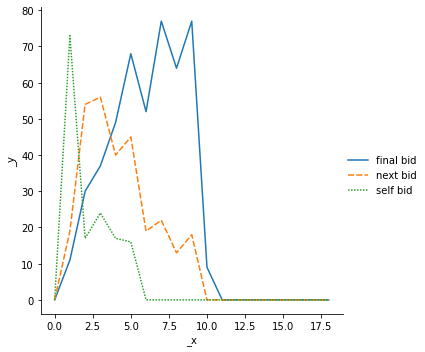

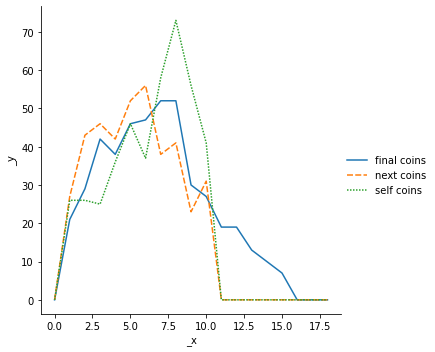

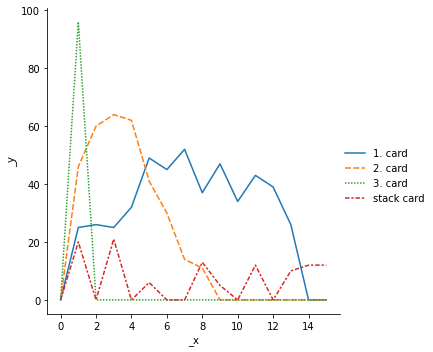

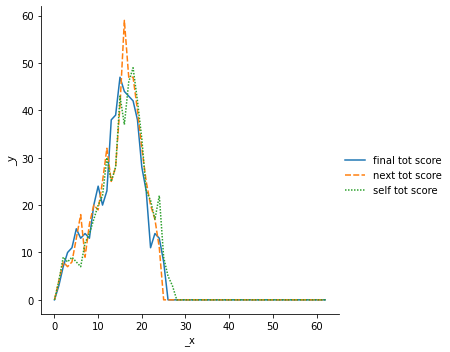

In [446]:
output = y_test[10]
bidplot = sns.relplot(data=bid_df, kind="line")
coin_plot = sns.relplot(data=coin_df, kind="line")
card_plot = sns.relplot(data=card_df, kind="line")
tot_plot = sns.relplot(data=tot_df, kind="line")



# sns.displot(data=new_df)
# sns.catplot(data=new_df, kind="box")
# sns.kdeplot(data=new_df)

In [264]:
df

,3. card,2. card,1. card
0,0.0,0.0,0.0
1,27.0,21.0,12.0
2,-3.0,18.0,7.0
3,-8.0,18.0,13.0
4,-14.0,27.0,9.0
5,-10.0,31.0,17.0
6,-12.0,19.0,12.0
7,-10.0,15.0,19.0
8,-17.0,9.0,16.0
9,-12.0,-2.0,23.0


In [50]:
b1 = [13, 12, 10]
example1 = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
b2 = [5, 3, 2]
example2 = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
b3 = [10, 3, 2]
example3 = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

b4 = [14, 8, 7]
example4 = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
best_models[-1][1].predict(example2)
c_out2 = best_models[-1][1].transform(example2.reshape(1, -1))
c_out1 = best_models[-1][1].transform(example1.reshape(1, -1))

diff = np.where(c_out1 != c_out2)

def get_diff_graphs(clauses_out):
    grouped_intervals = defaultdict(list)
    for group in groups_and_value:
        grouped_intervals[group[0]] = get_pos_interval(tm, clauses_out, (group[1], group[2]))
    return grouped_intervals


In [222]:
def create_plots_from_single_example(tm, ex):
    ex = np.delete(ex, self_can_bet_index)
    c_out = tm.transform(ex.reshape(1, -1))
    clauses_out = np.where(c_out == 1)[1].astype(int)
    grouped_intervals = defaultdict(list)
    for group in groups_and_value:
        grouped_intervals[group[0]] = get_pos_interval(tm, clauses_out, (group[1], group[2]))
    return grouped_intervals


def create_plots_from_clauses_out(tm, clauses):
    grouped_intervals = defaultdict(list)
    for group in groups_and_value:
        grouped_intervals[group[0]] = get_pos_interval(tm, clauses, (group[1], group[2]))
    return grouped_intervals

def create_plots_from_example_with_y(tm, ex, y):
    ex = np.delete(ex, self_can_bet_index)
    c_out = tm.transform(ex.reshape(1, -1))
    clauses_out = np.where(c_out == 1)[1].astype(int)
    mw = tm.weight_banks[y].get_weights()
    new_c_out = mw[clauses_out]
    clauses_out = clauses_out[new_c_out > 0]
    grouped_intervals = defaultdict(list)
    for group in groups_and_value:
        grouped_intervals[group[0]] = get_pos_interval(tm, clauses_out, (group[1], group[2]))
    return grouped_intervals

In [27]:

g_ints1 = create_plots_from_single_example(best_models[-1][1], example1)
g_ints2 = create_plots_from_single_example(best_models[-1][1], example2)



something was wrong with:  final can bid  


In [234]:
# g_ints4 = create_plots_from_single_example(best_models[-1][1], example4)
pos_ints1 = create_plots_from_example_with_y(best_tms[-1][1], example1, best_tms[-1][1].predict(example1)[0])
pos_ints2 = create_plots_from_example_with_y(best_tms[-1][1], example2, best_tms[-1][1].predict(example2)[0])
pos_ints3 = create_plots_from_example_with_y(best_tms[-1][1], example3, best_tms[-1][1].predict(example3)[0])


something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something was wrong with:  final can bid  
something w

In [246]:
pos_ints4 = create_plots_from_example_with_y(best_tms[-3][1], example4, best_tms[-3][1].predict(example4)[0])
create

In [251]:
pos_ints4

defaultdict(list,
            {'cards': {'1. card': array([ 0.,  1.,  2.,  4.,  8., 10.,  8.,  7., 11.,  7.,  8.,  4.,  8.,
                      7.,  9.,  0.]),
              '2. card': array([ 0.,  4.,  9., 12., 11., 17.,  7.,  5.,  9.,  0.,  0.,  0.,  0.,
                      0.,  0.,  0.]),
              '3. card': array([ 0., 23.,  8.,  8.,  3.,  1.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,
                      0.,  0.,  0.]),
              'stack card': array([ 0.,  3.,  0.,  0.,  5.,  4., 10.,  8.,  5., 10.,  0.,  8., 11.,
                     11.,  9., 11.])},
             'orders': {'final order': array([0., 0., 0., 0.]),
              'next order': array([ 0.,  0.,  0., 29.]),
              'self order': array([0., 0., 0., 0.])},
             'scores': {'final pass score': array([ 0.,  0.,  1.,  0.,  1.,  0.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,
                      2.,  0.,  0.,  1.,  1.,  4.,  2.,  3.,  1.,  4.,  5.,  5., 10.,
                      7.,  4., 10., 11., 12.,  5.,  

In [244]:
print("with feature negation:")
print(best_models[-1][1].predict(example1.reshape(1, -1)))
print(best_models[-1][1].predict(example2.reshape(1, -1)))
print(best_models[-1][1].predict(example3.reshape(1, -1)))
print(best_models[-1][1].predict(example4.reshape(1, -1)))
print("without feature negation: ")
print(best_tms[-3][1].predict(example1.reshape(1, -1)))
print(best_tms[-3][1].predict(example2.reshape(1, -1)))
print(best_tms[-3][1].predict(example3.reshape(1, -1)))
print(best_tms[-3][1].predict(example4.reshape(1, -1)))

with feature negation:
[2]
[2]
[4]
[4]
without feature negation: 
[0]
[0]
[0]
[12]


In [241]:
pos_ints4

defaultdict(list,
            {'cards': {'1. card': array([0., 1., 2., 0., 3., 1., 2., 0., 4., 1., 2., 0., 0., 1., 0., 0.]),
              '2. card': array([0., 2., 2., 1., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
              '3. card': array([0., 2., 5., 2., 2., 3., 3., 6., 0., 0., 0., 0., 0., 0., 0., 0.]),
              'stack card': array([0., 1., 0., 0., 0., 0., 1., 1., 5., 2., 0., 2., 6., 5., 1., 4.])},
             'orders': {'final order': array([0., 0., 0., 0.]),
              'next order': array([0., 0., 0., 5.]),
              'self order': array([ 0.,  0., 16.,  0.])},
             'scores': {'final pass score': array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
                     2., 1., 0., 4., 0., 0., 4., 0., 1., 0., 0., 1., 0., 1., 2., 0., 1.,
                     1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
              'final tot score': a

[13, 12, 10]


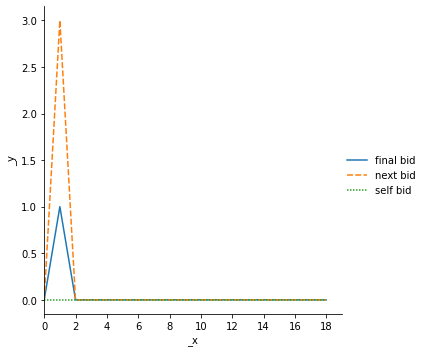

[5, 3, 2]


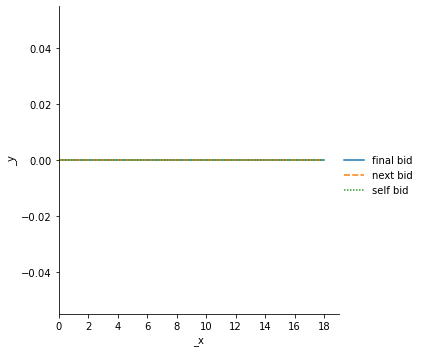

[14, 8, 7]


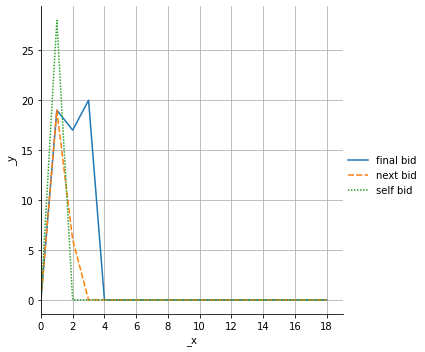

[13, 12, 10]


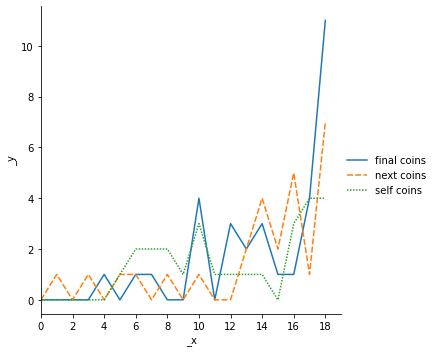

[5, 3, 2]


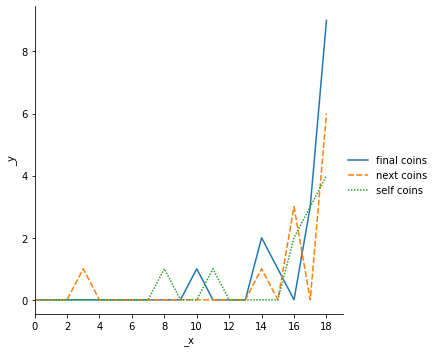

[14, 8, 7]


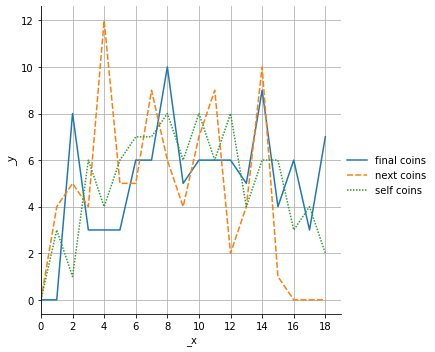

[13, 12, 10]


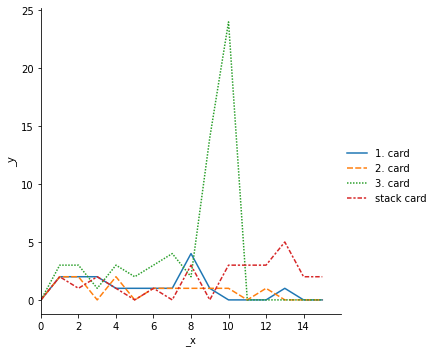

[5, 3, 2]


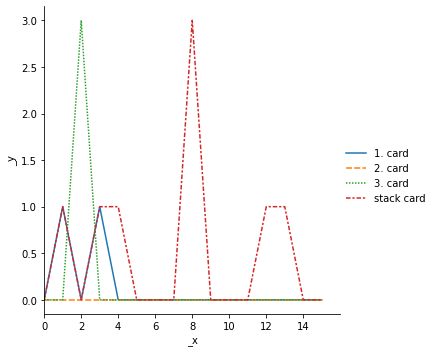

[14, 8, 7]


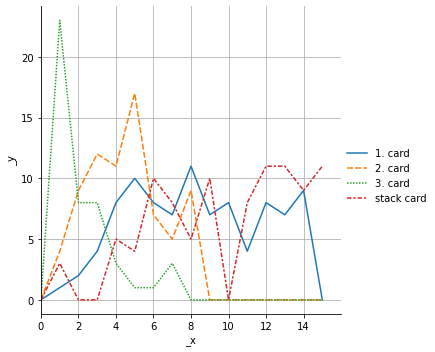

[13, 12, 10]


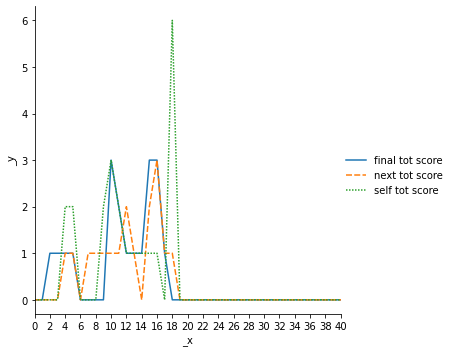

[5, 3, 2]


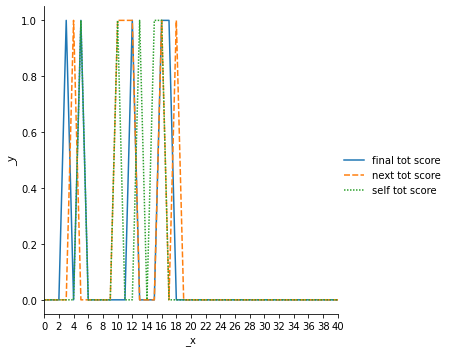

[14, 8, 7]


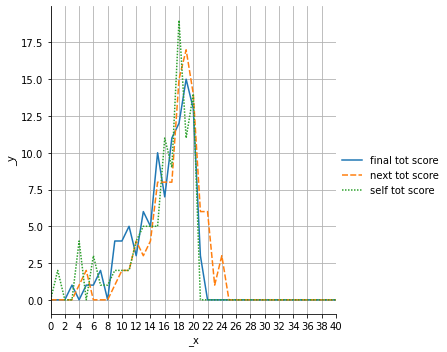

[13, 12, 10]


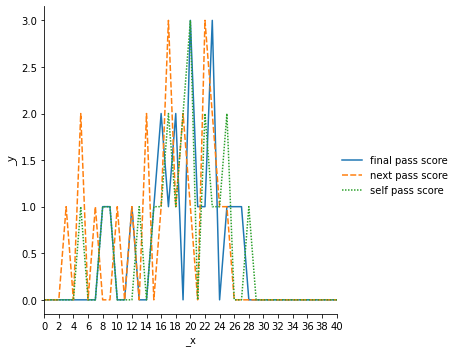

[5, 3, 2]


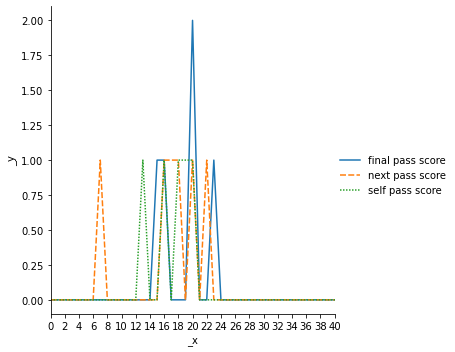

[14, 8, 7]


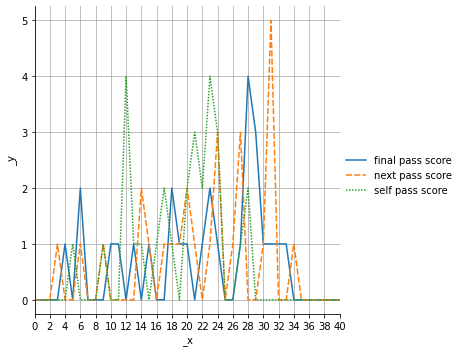

In [247]:
print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints1["bids"].items()}), kind="line")
plt.xlim(0, 19)
plt.xticks(range(0, 20, 2))
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints2["bids"].items()}), kind="line")
plt.xlim(0, 19)
plt.xticks(range(0, 20, 2))
plt.show()
print(b4)
# sns.relplot(data=pd.DataFrame({k: v for k,v in ex4_filtered_plot["bids"].items()}), kind="line")
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints4["bids"].items()}), kind="line")
plt.xlim(0, 19)
plt.xticks(range(0, 20, 2))
plt.grid()
plt.show()

print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints1["coins"].items()}), kind="line")
plt.xlim(0, 19)
plt.xticks(range(0, 19, 2))
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints2["coins"].items()}), kind="line")
plt.xlim(0, 19)
plt.xticks(range(0, 19, 2))
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints4["coins"].items()}), kind="line")
plt.xlim(0, 19)
plt.xticks(range(0, 19, 2))
plt.grid()
plt.show()

print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints1["cards"].items()}), kind="line")
plt.xlim(0, 16)
plt.xticks(range(0, 16, 2))
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints2["cards"].items()}), kind="line")
plt.xlim(0, 16)
plt.xticks(range(0, 16, 2))
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints4["cards"].items()}), kind="line")
plt.xlim(0, 16)
plt.xticks(range(0, 16, 2))
plt.grid()
plt.show()


print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints1["scores"].items() if "tot" in k}), kind="line")
plt.xlim(0, 40)
plt.xticks(range(0, 41, 2))
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints2["scores"].items() if "tot" in k}), kind="line")
plt.xlim(0, 40)
plt.xticks(range(0, 41, 2))
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints4["scores"].items() if "tot" in k}), kind="line")
plt.xlim(0, 40)
plt.xticks(range(0, 41, 2))
plt.grid()
plt.show()

print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints1["scores"].items() if "tot" not in k}), kind="line")
plt.xlim(0, 40)
plt.xticks(range(0, 41, 2))
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints2["scores"].items() if "tot" not in k}), kind="line")
plt.xlim(0, 40)
plt.xticks(range(0, 41, 2))
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in ex4_filtered_plot["scores"].items() if "tot" not in k}), kind="line")
plt.xlim(0, 40)
plt.xticks(range(0, 41, 2))
plt.grid()
plt.show()

In [58]:
cards1 = pd.DataFrame({k: v for k,v in g_ints1["cards"].items()})
print(np.argmax(cards1.sum(axis=1)))
cards2 = pd.DataFrame({k: v for k,v in g_ints2["cards"].items()})
print(np.argmax(cards2.sum(axis=1)))
cards4 = pd.DataFrame({k: v for k,v in g_ints4["cards"].items()})
print(np.argmax(cards4.sum(axis=1)))


scores1 = pd.DataFrame({k: v for k,v in g_ints1["scores"].items() if "tot" in k})
print(np.argmax(scores1.sum(axis=1)))
scores2 = pd.DataFrame({k: v for k,v in g_ints2["scores"].items() if "tot" in k})
print(np.argmax(scores2.sum(axis=1)))

2
2
1
16
18


[13, 12, 10]


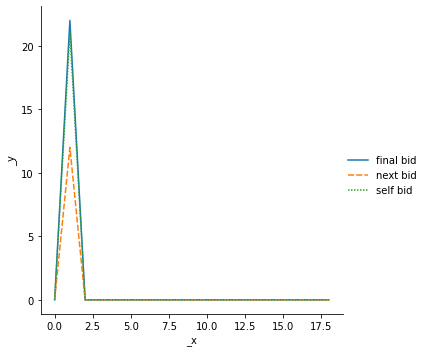

[5, 3, 2]


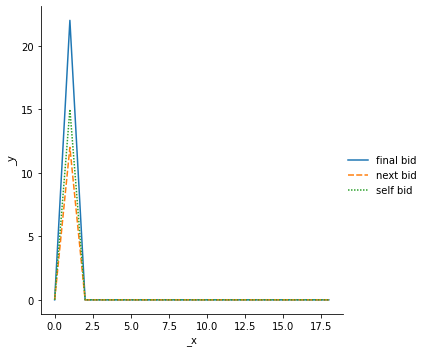

[14, 8, 7]


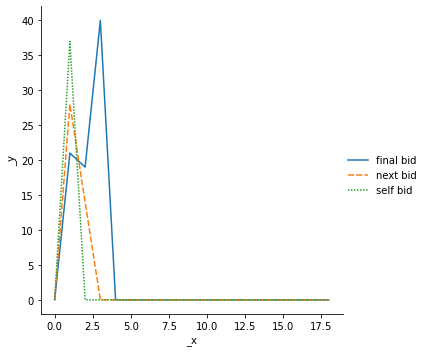

[13, 12, 10]


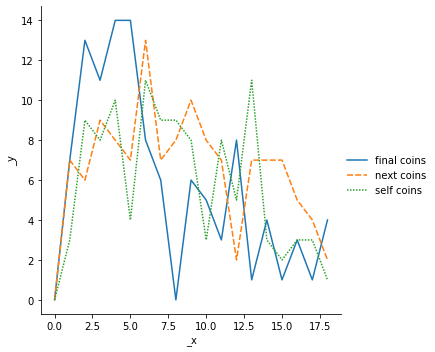

[5, 3, 2]


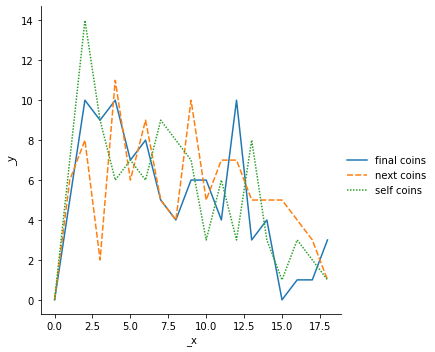

[14, 8, 7]


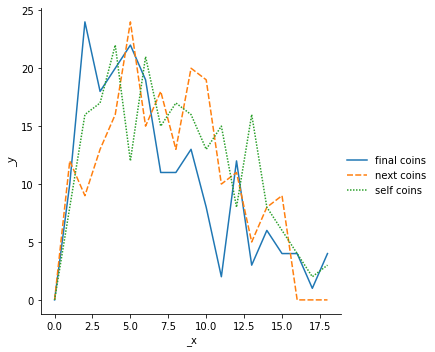

[13, 12, 10]


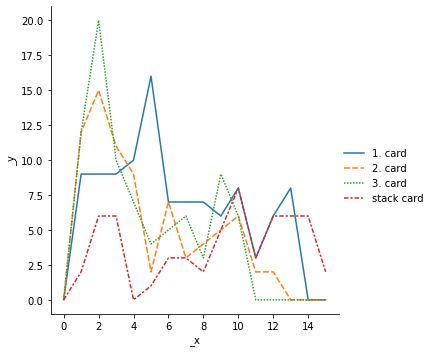

[5, 3, 2]


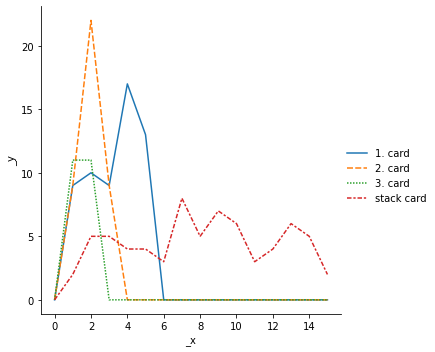

[14, 8, 7]


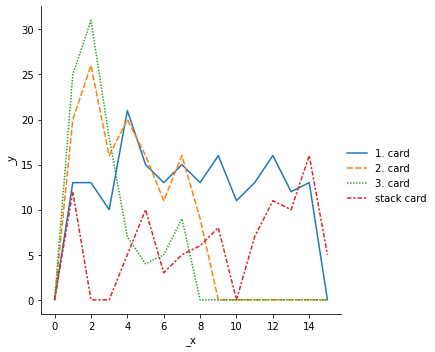

[13, 12, 10]


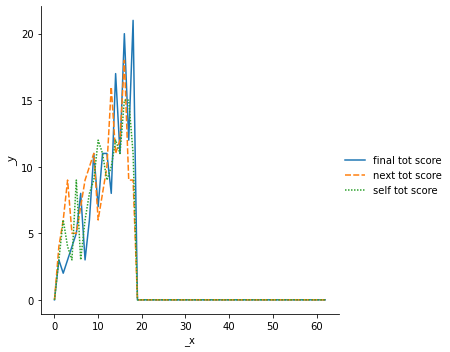

[5, 3, 2]


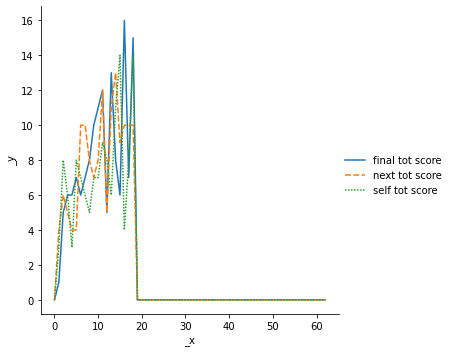

[14, 8, 7]


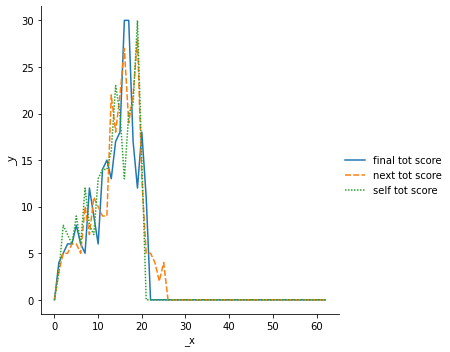

[13, 12, 10]


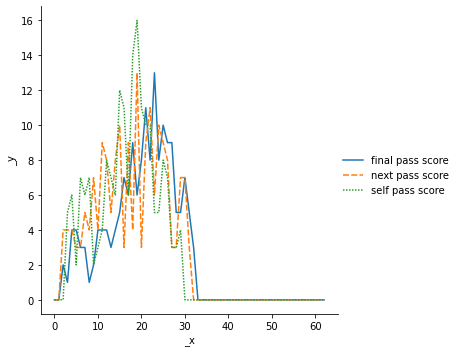

[5, 3, 2]


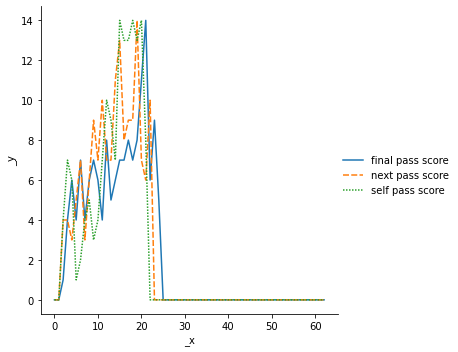

[14, 8, 7]


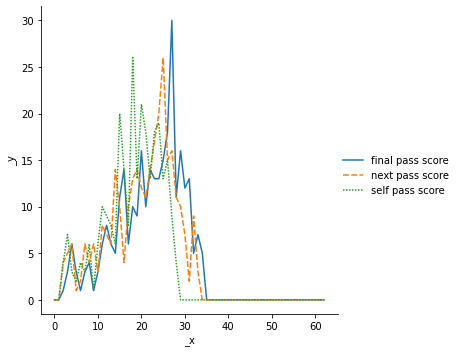

In [55]:
print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints1["bids"].items()}), kind="line")
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints2["bids"].items()}), kind="line")
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints4["bids"].items()}), kind="line")
plt.show()

print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints1["coins"].items()}), kind="line")
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints2["coins"].items()}), kind="line")
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints4["coins"].items()}), kind="line")
plt.show()

print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints1["cards"].items()}), kind="line")
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints2["cards"].items()}), kind="line")
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints4["cards"].items()}), kind="line")
plt.show()

print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints1["scores"].items() if "tot" in k}), kind="line")
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints2["scores"].items() if "tot" in k}), kind="line")
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints4["scores"].items() if "tot" in k}), kind="line")
plt.show()

print(b1)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints1["scores"].items() if "tot" not in k}), kind="line")
plt.show()
print(b2)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints2["scores"].items() if "tot" not in k}), kind="line")
plt.show()
print(b4)
sns.relplot(data=pd.DataFrame({k: v for k,v in g_ints4["scores"].items() if "tot" not in k}), kind="line")
plt.show()


In [459]:
single_score_df = pd.DataFrame({k: v for k, v in grouped_intervals_single_ex["scores"].items()})
single_bid_df = pd.DataFrame({k: v for k,v in grouped_intervals_single_ex["bids"].items()})
single_coin_df = pd.DataFrame({k: v for k,v in grouped_intervals_single_ex["coins"].items()})
single_card_df = pd.DataFrame({k: v for k,v in grouped_intervals_single_ex["cards"].items()})
single_tot_df = pd.DataFrame({k: v for k,v in grouped_intervals_single_ex["scores"].items() if "tot" in k})


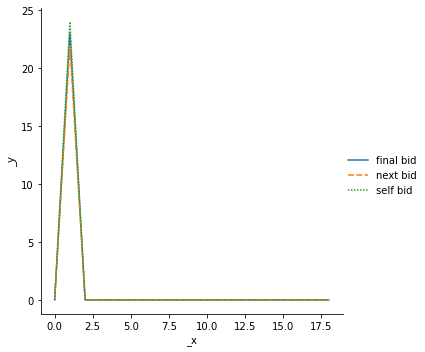

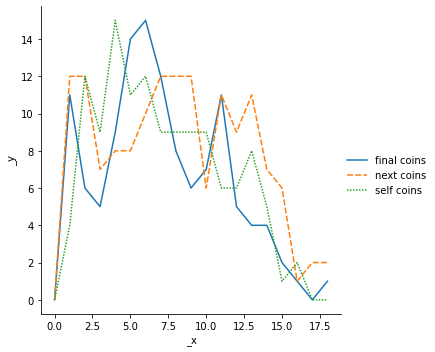

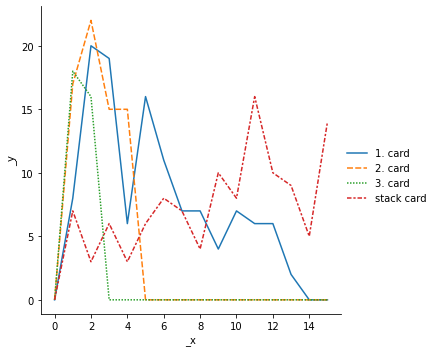

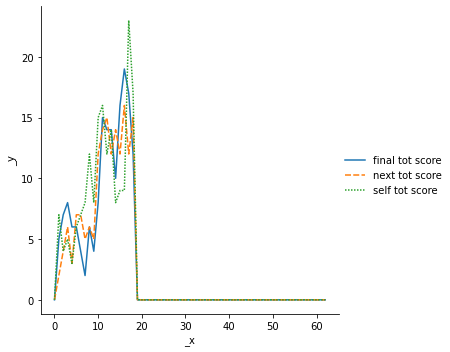

In [460]:
bidplot = sns.relplot(data=single_bid_df, kind="line")
coin_plot = sns.relplot(data=single_coin_df, kind="line")
card_plot = sns.relplot(data=single_card_df, kind="line")
tot_plot = sns.relplot(data=single_tot_df, kind="line")

In [461]:
best_models[-1][1].predict(single_example)[0]

4

<AxesSubplot:ylabel='Density'>

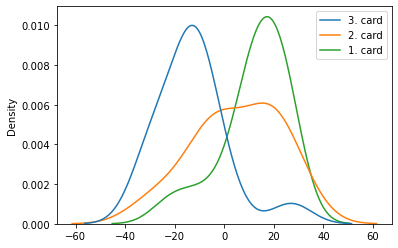

In [263]:
col = list(range(0, 16))
df = pd.DataFrame({"3. card": ints[0]["3. card"], "2. card": ints[1]["2. card"], "1. card": ints[2]["1. card"]})
sns.kdeplot(data=df)

In [304]:
def show_coalesced_weight(tm, the_class, weight):
    mw = tm.weight_banks[the_class].get_weights()
    return mw[weight]


def show_coalesced_clause_4r(tm, clause):
    number_of_features = 556
    # print("Clause #%d: " % (clause), end=' ')
    l = []
    for k in range(number_of_features*2):
        if tm.get_ta_action(clause, k) == 1:
            if k < number_of_features:
                l.append(" "+get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
    return " ∧ ".join(l)

In [303]:
def get_string_coalesced_clause_4r(tm, clause):
    number_of_features = 556
    # print("Clause #%d: " % (clause), end=' ')
    l = []
    for k in range(number_of_features*2):
        if tm.get_ta_action(clause, k) == 1:
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
    return l

In [302]:
def prepare_tm_for_apriori(x, y, tm, sigma=0):
    c_out = tm.transform(x.reshape(1, -1))
    clauses_out = np.where(c_out == 1)[1].astype(int)
    mw = tm.weight_banks[y].get_weights()
    weight_to_plot = mw[clauses_out]
    clauses_out_r = clauses_out[abs(weight_to_plot) > sigma]
    return clauses_out_r

In [127]:
c_out = best_tms[-1][1].transform(example4.reshape(1, -1))
clauses_out = np.where(c_out == 1)[1].astype(int)
mw = best_tms[-1][1].weight_banks[best_tms[-1][1].predict(example4.reshape(1, -1))[0]].get_weights()
new_c_out = mw[clauses_out]
# print(mw, clauses_out)
ex4_filter = clauses_out[new_c_out > 0]
# ex4_filtered_plot = create_plots_from_clauses_out(best_tms[-1][1], ex4_filter)
ex4_list = [reduce_coalesce_clause_4r(best_tms[-1][1], clause) for clause in ex4_filter]
te = TransactionEncoder()
te_ary = te.fit(ex4_list).transform(ex4_list)
df_ex4 = pd.DataFrame(te_ary, columns=te.columns_)
print(best_tms[-1][1].predict(example4.reshape(1, -1)))

[0]


In [296]:
frequent_itemsets = apriori(df_ex4, min_support=0.013, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
pd.set_option('max_colwidth', 1000)
# frequent_itemsets[ (frequent_itemsets["length"] > 2) & (frequent_itemsets["support"] >= 0.05)]
frequent_itemsets [ frequent_itemsets["length"] >= 2]

,support,itemsets,length
23,0.025974,"(next tot score 16, next coins 16)",2


In [290]:
130 * 0.6

78.0

In [128]:

c_out = best_tms[-1][1].transform(example3.reshape(1, -1))
clauses_out = np.where(c_out == 1)[1].astype(int)
mw = best_tms[-1][1].weight_banks[best_tms[-1][1].predict(example3.reshape(1, -1))[0]].get_weights()
new_c_out = mw[clauses_out]
# print(mw, clauses_out)
ex3_filter = clauses_out[new_c_out > 0]
# ex4_filtered_plot = create_plots_from_clauses_out(best_tms[-1][1], ex4_filter)
ex3_list = [reduce_coalesce_clause_4r(best_tms[-1][1], clause) for clause in ex3_filter]
te = TransactionEncoder()
te_ary = te.fit(ex3_list).transform(ex3_list)
df_ex3 = pd.DataFrame(te_ary, columns=te.columns_)
print(best_tms[-1][1].predict(example3.reshape(1, -1)))

[2]


In [131]:
frequent_itemsets = apriori(df_ex3, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
pd.set_option('max_colwidth', 1000)
# frequent_itemsets[ (frequent_itemsets["length"] > 2) & (frequent_itemsets["support"] >= 0.05)]
frequent_itemsets [ frequent_itemsets["length"] >= 2]

,support,itemsets,length
18,0.018519,"(self tot score 14, final pass score 27)",2
19,0.018519,"(next tot score 15, next coins 17)",2
20,0.018519,"(self tot score 14, next coins 17)",2
21,0.018519,"(next pass score 17, next tot score 15)",2
22,0.018519,"(self tot score 14, next tot score 15)",2
23,0.018519,"(self tot score 14, next tot score 15, next coins 17)",3


In [147]:
print(show_coalesced_clause_4r(cuda_tm, 65))
print(reduce_coalesce_clause_4r(cuda_tm, 65))

 self tot score 2 ∧  self tot score 3 ∧  self tot score 4 ∧  self tot score 5 ∧  self tot score 6 ∧  self tot score 7 ∧  self tot score 8 ∧  self tot score 9 ∧  self tot score 11 ∧  self tot score 13 ∧  self tot score 14 ∧  self tot score 15 ∧  self tot score 19 ∧  self tot score 20 ∧  self tot score 21 ∧  self tot score 23 ∧  self tot score 24 ∧  self tot score 25 ∧  self tot score 26 ∧  self tot score 28 ∧  self tot score 29 ∧  self pass score 2 ∧  self pass score 4 ∧  self pass score 5 ∧  self pass score 6 ∧  self pass score 8 ∧  self pass score 9 ∧  self pass score 10 ∧  self pass score 11 ∧  self pass score 12 ∧  self pass score 13 ∧  self pass score 14 ∧  self pass score 17 ∧  self pass score 20 ∧  self pass score 21 ∧  self pass score 27 ∧  self pass score 30 ∧  self pass score 31 ∧  self pass score 34 ∧  self pass score 35 ∧  next tot score 1 ∧  next tot score 3 ∧  next tot score 4 ∧  next tot score 6 ∧  next tot score 7 ∧  next tot score 8 ∧  next tot score 10 ∧  next tot scor

In [308]:
# oversette output cumulativ til > nummer eller < nummer


def reduce_coalesce_clause_4r(tm, clause):
    # negation
    # else:
    # l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
    own_money = list(range(18))
    high_own_money = (0, "")
    neg_own_money = (99, "")
    own_total_score = list(range(18, 80))
    high_own_total_score = (0, "")
    neg_own_total_score = (99, "")
    own_bid = list(range(80, 98))
    high_own_bid = (0, "")
    neg_own_bid = (99, "")
    own_pass_score = list(range(98, 160))
    high_own_pass_score = (0, "")
    neg_own_pass_score = (99, "")
    own_pass_order = list(range(160, 163))
    
    next_coins = list(range(163, 181))
    high_next_coins = (0, "")
    neg_next_coins = (99, "")
    next_tot_score = list(range(181, 243))
    high_next_tot_score = (0, "")
    neg_next_tot_score = (99, "")
    next_bid = list(range(243, 261))
    high_next_bid = (0, "")
    neg_next_bid = (99, "")
    next_pass_score = list(range(261, 323))
    high_next_pass_score = (0, "")
    neg_next_pass_score = (99, "")
    next_order = list(range(323, 326))
    next_can_bid = 326

    final_coins = list(range(327, 345))
    high_final_coins = (0, "")
    neg_final_coins = (99, "")
    final_tot_score = list(range(345, 407))
    high_final_tot_score = (0, "")
    neg_final_tot_score = (99, "")
    final_bid = list(range(407, 425))
    high_final_bid = (0, "")
    neg_final_bid = (99, "")
    final_pass_score = list(range(425, 487))
    high_final_pass_score = (0, "")
    neg_final_pass_score = (99, "")
    final_order = list(range(487, 490))
    final_can_bid = 490

    stack_card = list(range(491, 506))
    board_c1 = list(range(506, 521))
    high_board_c1 = (0, "")
    neg_board_c1 = (99, "")
    board_c2 = list(range(521, 536))
    high_board_c2 = (0, "")
    neg_board_c2 = (99, "")
    board_c3 = list(range(536, 551))
    high_board_c3 = (0, "")
    neg_board_c3 = (99, "")
    std_bit = 551

    
    number_of_features = 552
    l = []
    for k in range(number_of_features*2):
        if tm.get_ta_action(clause, k) == 1 and k in own_money:# or k in double(own_money):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_money[0]:
                    high_own_money = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_own_money[0]:
                    neg_own_money = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and k in own_total_score:# or k in double(own_total_score):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_total_score[0]:
                    high_own_total_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_own_total_score[0]:
                    neg_own_total_score = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and k in own_bid:# or k in double(own_bid):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_bid[0]:
                    high_own_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_own_bid[0]:
                    neg_own_bid = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and k in own_pass_score:# or k in double(own_pass_score):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_pass_score[0]:
                    high_own_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_own_pass_score[0]:
                    neg_own_pass_score = (int(name[-2:]), name)
                    
        # find out what to do about this one!
        elif tm.get_ta_action(clause, k) == 1 and k in own_pass_order:# or k in double(own_pass_order):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                
                  
        elif tm.get_ta_action(clause, k) == 1 and k in next_coins:# or k in double(next_coins):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_coins[0]:
                    high_next_coins = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_next_coins[0]:
                    neg_next_coins = (int(name[-2:]), name)
            
        elif tm.get_ta_action(clause, k) == 1 and k in next_tot_score:# or k in double(next_tot_score):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_tot_score[0]:
                    high_next_tot_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_next_tot_score[0]:
                    neg_next_tot_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and k in next_bid:# or k in double(next_bid):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_bid[0]:
                    high_next_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_next_bid[0]:
                    neg_next_bid = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and k in next_pass_score:# or k in double(next_pass_score):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_pass_score[0]:
                    high_next_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_next_pass_score[0]:
                    neg_next_pass_score = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and k in next_order:# or k in double(next_order):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                
        elif tm.get_ta_action(clause, k) == 1 and k == next_can_bid:# or k == next_can_bid + number_of_features:
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))        
                
        elif tm.get_ta_action(clause, k) == 1 and k in final_coins:# or k in double(final_coins):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_coins[0]:
                    high_final_coins = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_final_coins[0]:
                    neg_final_coins = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and k in final_tot_score:# or k in double(final_tot_score):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_tot_score[0]:
                    high_final_tot_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_final_tot_score[0]:
                    neg_final_tot_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and k in final_bid:# or k in double(final_bid):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_bid[0]:
                    high_final_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_final_bid[0]:
                    neg_final_bid = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and k in final_pass_score:# or k in double(final_pass_score):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_pass_score[0]:
                    high_final_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_final_pass_score[0]:
                    neg_final_pass_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and k in final_order:# or k in double(final_order):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
                # l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
        elif tm.get_ta_action(clause, k) == 1 and k == final_can_bid:# or k == final_can_bid + number_of_features:
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
        
        elif tm.get_ta_action(clause, k) == 1 and k in board_c1:# or k in double(board_c1):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c1[0]:
                    high_board_c1 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_board_c1[0]:
                    neg_board_c1 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and k in board_c2:# or k in double(board_c2):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c2[0]:
                    high_board_c2 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_board_c2[0]:
                    neg_board_c2 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and k in board_c3:# or k in double(board_c3):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c3[0]:
                    high_board_c3 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) < neg_board_c3[0]:
                    neg_board_c3 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and k == std_bit:# or k == std_bit + number_of_features:
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                    
        # else:
        #     if k < number_of_features:
        #         l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
    
    l.append(high_own_money[1]) if high_own_money[1] != "" else None
    l.append(neg_own_money[1]) if neg_own_money[1] != "" else None
    l.append(high_own_bid[1]) if high_own_bid[1] != "" else None
    l.append(neg_own_bid[1]) if high_own_bid[1] != "" else None
    l.append(high_own_total_score[1]) if high_own_total_score[1] != "" else None
    l.append(neg_own_total_score[1]) if high_own_total_score[1] != "" else None
    l.append(high_own_pass_score[1]) if high_own_pass_score[1] != "" else None
    l.append(neg_own_pass_score[1]) if high_own_pass_score[1] != "" else None
    
    l.append(high_next_coins[1]) if high_next_coins[1] != "" else None
    l.append(neg_next_coins[1]) if high_next_coins[1] != "" else None
    l.append(high_next_tot_score[1]) if high_next_tot_score[1] != "" else None
    l.append(neg_next_tot_score[1]) if high_next_tot_score[1] != "" else None
    l.append(high_next_bid[1]) if high_next_bid[1] != "" else None
    l.append(neg_next_bid[1]) if high_next_bid[1] != "" else None
    l.append(high_next_pass_score[1]) if high_next_pass_score[1] != "" else None
    l.append(neg_next_pass_score[1]) if high_next_pass_score[1] != "" else None
    
    l.append(high_final_coins[1]) if high_final_coins[1] != "" else None
    l.append(neg_final_coins[1]) if high_final_coins[1] != "" else None
    l.append(high_final_tot_score[1]) if high_final_tot_score[1] != "" else None
    l.append(neg_final_tot_score[1]) if high_final_tot_score[1] != "" else None
    l.append(high_final_bid[1]) if high_final_bid[1] != "" else None
    l.append(neg_final_bid[1]) if high_final_bid[1] != "" else None
    l.append(high_final_pass_score[1]) if high_final_pass_score[1] != "" else None
    l.append(neg_final_pass_score[1]) if high_final_pass_score[1] != "" else None
    
    l.append(high_board_c1[1]) if high_board_c1[1] != "" else None
    l.append(neg_board_c1[1]) if high_board_c1[1] != "" else None
    l.append(high_board_c2[1]) if high_board_c2[1] != "" else None
    l.append(neg_board_c2[1]) if high_board_c2[1] != "" else None
    l.append(high_board_c3[1]) if high_board_c3[1] != "" else None
    l.append(neg_board_c3[1]) if high_board_c3[1] != "" else None
    l = [i for i in l if i != ""]
    return l

# for i in range(n_clauses_per_class):
#     if i % 1000 == 0:
#         print(i)
reduce_coalesce_clause_4r(cuda_tm, 65)


['next order 3',
 'self tot score 29',
 'self pass score 35',
 'next tot score 26',
 'next bid 1',
 'next pass score 33',
 'final tot score 26',
 'final pass score 33',
 '1. card 4',
 '2. card 1',
 '3. card 2']

In [154]:
# neg_cuda_tm.literal_clause_frequency()
np.where(cuda_tm.clause_co_occurrence(example4, percentage=True).toarray() > 0)[1].shape

(1611931,)

In [104]:
reduce_neg_coalesce_clause_4r(neg_cuda_tm, 600)

['self pass score 62']

In [326]:
df

,1. card 1,1. card 10,1. card 11,1. card 12,1. card 13,1. card 14,1. card 2,1. card 3,1. card 4,1. card 5,...,¬self tot score 56,¬self tot score 57,¬self tot score 58,¬self tot score 59,¬self tot score 60,¬self tot score 61,¬self tot score 62,¬stack card 10,¬stack card 2,¬std bit
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
198,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
199,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
200,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [328]:
ex4_nobid = np.delete(example4, self_can_bet_index)
print(best_models)
neg_cuda_tm

[(79.98587422831433, <tmu.tsetlin_machine.TMCoalescedClassifier object at 0x7f37873373a0>), (82.71816469603432, <tmu.tsetlin_machine.TMCoalescedClassifier object at 0x7f37873373a0>)]


In [349]:
df = single_tm_apriori(x_test[10], 4, neg_cuda_tm, sigma=0)
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
pd.set_option('max_colwidth', 1000)
frequent_itemsets

,support,itemsets,length
0,0.034043,(1. card 1),1
1,0.012766,(1. card 10),1
2,0.034043,(1. card 2),1
3,0.055319,(1. card 3),1
4,0.034043,(1. card 4),1
...,...,...,...
937,0.012766,"(¬next pass score 62, ¬3. card 14, ¬final tot score 61)",3
938,0.012766,"(¬next pass score 62, ¬3. card 14, ¬next tot score 62)",3
939,0.012766,"(¬self tot score 57, ¬final coins 18, ¬next tot score 61)",3
940,0.012766,"(¬next pass score 62, ¬next tot score 61, ¬final pass score 59)",3


In [350]:
# df1 = single_tm_apriori(ex4_nobid, 4, neg_cuda_tm, sigma=0)
# df2 = single_tm_apriori(ex4_nobid, 4, best_models[-1][1], sigma=0)
# df3 = single_tm_apriori(ex4_nobid, 4, best_models[-2][1], sigma=0)

ensamble_clauses = []
for tm in [neg_cuda_tm, best_models[-1][1], best_models[-2][1]] :
    c_out = tm.transform(ex4_nobid.reshape(1, -1))
    clauses_out = np.where(c_out == 1)[1].astype(int)
    mw = tm.weight_banks[4].get_weights()
    new_c_out = mw[clauses_out]
    clauses_out = clauses_out[new_c_out > 0]
    
    clas_list = [reduce_neg_coalesce_literals_4r(tm, clause) for clause in clauses_out]
    ensamble_clauses.extend(clas_list)
    
te = TransactionEncoder()
te_ary = te.fit(ensamble_clauses).transform(ensamble_clauses)
df_clas = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df_clas, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
pd.set_option('max_colwidth', 1000)
frequent_itemsets

,support,itemsets,length
0,0.041169,(1. card 1),1
1,0.037185,(1. card 10),1
2,0.039841,(1. card 11),1
3,0.051793,(1. card 12),1
4,0.029216,(1. card 13),1
...,...,...,...
1304,0.013280,"(¬self tot score 62, ¬next bid 18, ¬final bid 17)",3
1305,0.010624,"(¬self bid 18, ¬next pass score 62, ¬final bid 17)",3
1306,0.014608,"(¬self bid 18, ¬self tot score 62, ¬final bid 17)",3
1307,0.011952,"(¬self tot score 62, ¬self pass score 61, ¬final bid 17)",3


In [342]:
# print(frequent_itemsets[  frequent_itemsets['support'] >= 0.1 ].to_latex(index=False))
print(frequent_itemsets[ (frequent_itemsets["length"] > 2) & (frequent_itemsets["support"] >= 0.011)].to_latex(index=False))

\begin{tabular}{rlr}
\toprule
 support &                                                   itemsets &  length \\
\midrule
0.011952 &      (self bid 1, ¬self pass score 62, ¬cards to aquire 2) &       3 \\
0.011952 &          (self bid 1, ¬final pass score 62, ¬final bid 17) &       3 \\
0.011952 &            (self bid 1, ¬self tot score 62, ¬final bid 17) &       3 \\
0.011952 &      (self bid 1, ¬next tot score 62, ¬self pass score 62) &       3 \\
0.011952 & (¬next pass score 62, ¬final pass score 62, ¬final bid 17) &       3 \\
0.013280 &      (¬next can bid  , ¬final tot score 62, ¬final bid 17) &       3 \\
0.011952 &                (¬self bid 18, ¬next bid 18, ¬final bid 17) &       3 \\
0.013280 &          (¬self tot score 62, ¬next bid 18, ¬final bid 17) &       3 \\
0.014608 &          (¬self bid 18, ¬self tot score 62, ¬final bid 17) &       3 \\
0.011952 &   (¬self tot score 62, ¬self pass score 61, ¬final bid 17) &       3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1813360/4228979112.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(frequent_itemsets[ (frequent_itemsets["length"] > 2) & (frequent_itemsets["support"] >= 0.011)].to_latex(index=False))


In [173]:
predicts = Counter()
for tm_tup in tm_ensamble:
    predicts[tm_tup[1].predict(example4.reshape(1, -1))[0]] += 1
predicts.most_common()

[(0, 2), (12, 1)]

In [181]:
y = predicts.most_common()[0][0]

def get_heaviest_weighted_clauses_for_class(tm, clas):
    clause_weight_list = []
    mw = tm.weight_banks[clas].get_weights()
    for c in np.sort(np.argpartition(mw, -5)[-5:]):
        clause_weight_list.append((mw[c], reduce_coalesce_clause_4r(tm, c)))
    return clause_weight_list
get_heaviest_weighted_clauses_for_class(tm_ensamble[-3][1], y)

[(305,
  ['final order 2',
   'self coins 12',
   'self bid 1',
   'self tot score 17',
   'self pass score 22',
   'next coins 6',
   'next tot score 19',
   'next pass score 25',
   'final coins 11',
   'final tot score 14',
   'final bid 4',
   'final pass score 18',
   '1. card 6',
   '2. card 3',
   '3. card 3']),
 (384,
  ['next order 3',
   'final order 2',
   'self coins 11',
   'self bid 1',
   'self tot score 19',
   'self pass score 18',
   'next coins 4',
   'next tot score 20',
   'next bid 3',
   'next pass score 24',
   'final coins 13',
   'final tot score 14',
   'final bid 4',
   'final pass score 18',
   '1. card 5',
   '2. card 3',
   '3. card 2']),
 (428,
  ['next order 3',
   'self coins 7',
   'self bid 1',
   'self tot score 19',
   'self pass score 23',
   'next coins 6',
   'next tot score 15',
   'next pass score 18',
   'final coins 13',
   'final tot score 14',
   'final bid 4',
   'final pass score 19',
   '1. card 5',
   '2. card 4',
   '3. card 3']),
 (3

In [300]:
def get_pos_weighted_clauses_for_class(tm, clas):
    mw = tm.weight_banks[clas].get_weights()
    clauses_out = np.where(mw > 0)[0]
    return clauses_out
clauses_out = get_pos_weighted_clauses_for_class(tm_ensamble[-3][1], y)

ensamble_clauses = []
for tm in tm_ensamble:
    clauses_out = get_pos_weighted_clauses_for_class(tm[1], y)
    clas_list = [reduce_coalesce_clause_4r(tm[1], clause) for clause in clauses_out]
    ensamble_clauses.extend(clas_list)
    
te = TransactionEncoder()
te_ary = te.fit(ensamble_clauses).transform(ensamble_clauses)
df_clas = pd.DataFrame(te_ary, columns=te.columns_)
y

KeyboardInterrupt: 

In [312]:
def single_tm_apriori(x, y, tm, sigma=-100000):
    pre_ap = prepare_tm_for_apriori(x, y, tm, sigma)
    check_clause = [reduce_neg_coalesce_literals_4r(tm, clause) for i, clause in enumerate(pre_ap) if show_coalesced_weight(cuda_tm, y_test[20], clause) > 0]
    new_check = []
    for clause in check_clause:
        temp = []
        for feat in clause:
            temp.append(feat.strip())
        new_check.append(temp)
    te = TransactionEncoder()
    te_ary = te.fit(new_check).transform(new_check)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    return df

In [347]:
frequent_itemsets = apriori(df_clas, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
pd.set_option('max_colwidth', 1000)
# frequent_itemsets[ (frequent_itemsets["length"] >= 2) & (frequent_itemsets["support"] >= 0.05)]
# frequent_itemsets [ frequent_itemsets["length"] >= 2]
frequent_itemsets

,support,itemsets,length
0,0.041169,(1. card 1),1
1,0.037185,(1. card 10),1
2,0.039841,(1. card 11),1
3,0.051793,(1. card 12),1
4,0.029216,(1. card 13),1
...,...,...,...
1304,0.013280,"(¬self tot score 62, ¬next bid 18, ¬final bid 17)",3
1305,0.010624,"(¬self bid 18, ¬next pass score 62, ¬final bid 17)",3
1306,0.014608,"(¬self bid 18, ¬self tot score 62, ¬final bid 17)",3
1307,0.011952,"(¬self tot score 62, ¬self pass score 61, ¬final bid 17)",3


In [184]:
n_clauses_per_class/len(best_tms[-1][1].weight_banks)

470.5882352941176